In [216]:
import pandas as pd
import numpy as np
import seaborn as sns
from random import gauss
from random import uniform
import matplotlib.pyplot as plt

Reference Scenario

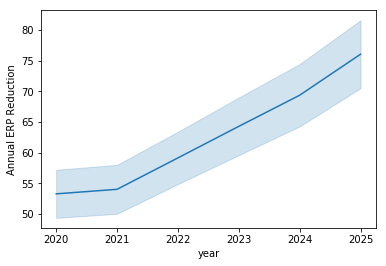

In [236]:
years = [2020, 2021, 2022, 2023, 2024, 2025]
TAM_size = [27775, 28488, 29160, 29836, 30515, 31064]
Target_Market_size_ref = [321, 330, 366, 403, 441, 490]
Total_DIRECT_GHG_footprint_of_TAM_ref = [13844, 13991, 14107, 14215, 14315, 14344]

#The class is built on values fed in from Crane Database
example = Report(years, TAM_size, Target_Market_size_ref, Total_DIRECT_GHG_footprint_of_TAM_ref)

#We can then tune values when we call the function
example.generate_report(Financial_FOM_mean = -.30,
                         Financial_FOM_stv = .02,
                         Physical_FOM_mean = .50,
                         Physical_FOM_stv = .02,
                         samples = 10000,
                         distribution = 'normal')

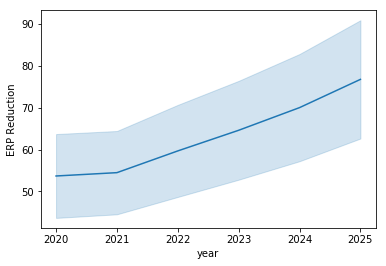

In [234]:
#The class is built on values fed in from Crane Database
example = Report(years, TAM_size, Target_Market_size_ref, Total_DIRECT_GHG_footprint_of_TAM_ref)

#We can then tune values when we call the function
example.generate_report(Financial_FOM_mean = -.30,
                         Financial_FOM_stv = .05,
                         Physical_FOM_mean = .50,
                         Physical_FOM_stv = .05,
                         samples = 10000,
                         distribution = 'normal')

In [235]:
class Report:
    def __init__(self, 
                 years, 
                 arr_TAM_size, 
                 arr_Target_Market_size_ref, 
                 arr_Total_DIRECT_GHG_footprint_of_TAM_ref):
        """
        Dynamic researcher values, change over time
        """
        self.arr_TAM_size = arr_TAM_size
        self.arr_Target_Market_size_ref = arr_Target_Market_size_ref
        self.arr_Total_DIRECT_GHG_footprint_of_TAM_ref = arr_Total_DIRECT_GHG_footprint_of_TAM_ref
        
        #assert inputs are of the same length
        assert (len(years) == len(arr_Target_Market_size_ref) &
                len(years) == len(arr_Total_DIRECT_GHG_footprint_of_TAM_ref) &
                len(years) == len(arr_TAM_size))
        
        self.years = years
        
        """
        Constant researcher values, consistent throughout time
        """
        self.INDIRECT_GHG_intensity_of_Target_Market_ref = 0.091558#numerator is MtCO2e; denominator varies by technology
        self.Total_DIRECT_GHG_footprint_of_Target_Market_ref = 0.0  # MtCO2e
        
        self.Elasticity_of_demand_for_Tarket_Market = -.75#unitless
        self.INDIRECT_GHG_intensity_of_Solution = 0.061039#numerator is MtCO2e; denominator varies by technology
        self.DIRECT_GHG_intensity_of_Solution = 0#numerator is MtCO2e; denominator varies by technology
        
        self.Market_Share_of_Solution = 1.00 # as percentage (%) of Target Market
        
    def create_datapoint(self,
                         TAM_size, 
                         Target_Market_size_ref, 
                         Total_DIRECT_GHG_footprint_of_TAM_ref, 
                         Financial_FOM_mean,
                         Financial_FOM_stv,
                         Physical_FOM_mean,
                         Physical_FOM_stv,
                         samples = 10000, 
                         distribution = 'normal'):
        
        
        #Setting Constants
        igiotmf = self.INDIRECT_GHG_intensity_of_Target_Market_ref
        tdgfotmf = self.Total_DIRECT_GHG_footprint_of_Target_Market_ref
        msos = self.Market_Share_of_Solution
        
        Elasticity_of_demand_for_Tarket_Market = self.Elasticity_of_demand_for_Tarket_Market#unitless
        INDIRECT_GHG_intensity_of_Solution  = self.INDIRECT_GHG_intensity_of_Solution #numerator is MtCO2e; denominator varies by technology
        DIRECT_GHG_intensity_of_Solution  = self.DIRECT_GHG_intensity_of_Solution #numerator is MtCO2e; denominator varies by technology
        
        Market_Share_of_Solution = self.Market_Share_of_Solution
        
        
        
        #Ref Scenario Calculations
        Remaining_Market_size_ref = TAM_size - Target_Market_size_ref #
        DIRECT_GHG_Intensity_of_TAM_ref = tdgfotmf/TAM_size# numerator is MtCO2e; denominator varies by technology
        DIRECT_GHG_Intensity_of_Remaining_Market = (Total_DIRECT_GHG_footprint_of_TAM_ref - tdgfotmf)/Remaining_Market_size_ref# numerator is MtCO2e; denominator varies by technology
        DIRECT_GHG_intensity_of_Target_Market_ref = Total_DIRECT_GHG_footprint_of_Target_Market_ref/Target_Market_size_ref# numerator is MtCO2e; denominator varies by technology
        
        Total_INDIRECT_GHG_footprint_of_Target_Market_ref = Target_Market_size_ref * igiotmf# MtCO2e
        Total_DIRECT_GHG_footprint_of_Remaining_Market_ref = Remaining_Market_size_ref * DIRECT_GHG_Intensity_of_Remaining_Market# MtCO2e
        Total_GHG_footprint_of_TAM_ref = Total_INDIRECT_GHG_footprint_of_Target_Market_ref + Total_DIRECT_GHG_footprint_of_Target_Market_ref + Total_DIRECT_GHG_footprint_of_Remaining_Market_ref#MtCO2e
        ###this is the value to compare

        erp_tmp = []

        for i in range(samples):
            
           # User input values in solution description
            
            if distribution == 'uniform':
                Relative_Financial_FOM = uniform(Financial_FOM_mean - Financial_FOM_stv, Financial_FOM_mean + Financial_FOM_stv) #%change
                Relative_Physical_FOM = uniform(Physical_FOM_mean - Physical_FOM_stv, Physical_FOM_mean + Physical_FOM_stv) #%change
            elif distribution == 'normal':
                Relative_Financial_FOM = gauss(Financial_FOM_mean, Financial_FOM_stv) #%change
                Relative_Physical_FOM = gauss(Physical_FOM_mean, Physical_FOM_stv) #%change
            else:
                print("not a real distribution")
                break
            
            
            #Solution Deployed Calculations
            
            Target_Market_size_sol = Target_Market_size_ref * (2/(1 - (Elasticity_of_demand_for_Tarket_Market * Market_Share_of_Solution*Relative_Financial_FOM /(2 + Market_Share_of_Solution*Relative_Financial_FOM))) - 1)# in Solution Scenario(s)
            Remaining_Market_size_sol = TAM_size - Target_Market_size_sol# in Solution Scenario(s)
            DIRECT_GHG_intensity_of_Target_Market_sol = DIRECT_GHG_intensity_of_Target_Market_ref*(1-Market_Share_of_Solution) + DIRECT_GHG_intensity_of_Solution * Market_Share_of_Solution# in Solution Scenario(s)
            Total_DIRECT_GHG_footprint_of_TAM_sol = Target_Market_size_sol * DIRECT_GHG_intensity_of_Target_Market_sol + Remaining_Market_size_sol * DIRECT_GHG_Intensity_of_Remaining_Market# in Solution Scenario(s)
            INDIRECT_GHG_intensity_of_Target_Marke_sol = INDIRECT_GHG_intensity_of_Target_Market_ref * (1 - Market_Share_of_Solution) + INDIRECT_GHG_intensity_of_Solution * Market_Share_of_Solution#  in Solution Scenario(s)
            Total_INDIRECT_GHG_footprint_of_Target_Market_sol = Target_Market_size_sol * INDIRECT_GHG_intensity_of_Target_Marke_sol# in Solution Scenario(s)
            Total_DIRECT_GHG_footprint_of_Target_Market_sol = Target_Market_size_sol * DIRECT_GHG_intensity_of_Target_Market_sol# in Solution Scenario(s)
            Total_DIRECT_GHG_footprint_of_Remaining_Market_sol = Remaining_Market_size_sol * DIRECT_GHG_Intensity_of_Remaining_Market# in Solution Scenario(s)
            
            Total_GHG_footprint_of_TAM_sol = Total_INDIRECT_GHG_footprint_of_Target_Market_sol + Total_DIRECT_GHG_footprint_of_Target_Market_sol + Total_DIRECT_GHG_footprint_of_Remaining_Market_sol# in Solution Scenario(s)
            ###this is the value to explore


            Emissions_Reduction_Potentional_annually = Total_GHG_footprint_of_TAM_ref  - Total_GHG_footprint_of_TAM_sol

            erp_tmp.append(Emissions_Reduction_Potentional_annually)
            
        erp_data = np.array(erp_tmp)
        # return lowerbound, mean, upperbound
        return np.mean(erp_data) - np.std(erp_data), np.mean(erp_data), np.mean(erp_data) + np.std(erp_data)

    def generate_report(self, 
                        Financial_FOM_mean, 
                        Financial_FOM_stv, 
                        Physical_FOM_mean,
                        Physical_FOM_stv,
                        samples = 10000,
                        distribution = 'normal'):
        
        plot_df = pd.DataFrame()
        
        arr_TAM_size= self.arr_TAM_size 
        arr_Target_Market_size_ref = self.arr_Target_Market_size_ref 
        arr_Total_DIRECT_GHG_footprint_of_TAM_ref = self.arr_Total_DIRECT_GHG_footprint_of_TAM_ref 
        
        #unit test for numbers
        for input_index, year in enumerate(self.years):
            # generate data point for the year
            lower_bound, mean, upper_bound = self.create_datapoint(
                         TAM_size = arr_TAM_size[input_index], 
                         Target_Market_size_ref = arr_Target_Market_size_ref[input_index], 
                         Total_DIRECT_GHG_footprint_of_TAM_ref = arr_Total_DIRECT_GHG_footprint_of_TAM_ref[input_index], 
                         Financial_FOM_mean = Financial_FOM_mean,
                         Financial_FOM_stv = Financial_FOM_stv,
                         Physical_FOM_mean = Physical_FOM_mean,
                         Physical_FOM_stv = Physical_FOM_stv,
                         samples = samples, 
                         distribution = distribution)
            plot_df = plot_df.append({"Annual ERP Reduction": lower_bound, "year": year}, ignore_index=True )
            plot_df = plot_df.append({"Annual ERP Reduction": mean, "year": year}, ignore_index=True )
            plot_df = plot_df.append({"Annual ERP Reduction": upper_bound, "year": year}, ignore_index=True )

        ax = sns.lineplot(x="year", y="Annual ERP Reduction", data=plot_df)
        #ax.set_xticklabels(rotation=45)    
        plt.xticks(self.years)


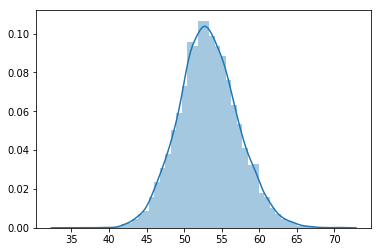

In [143]:
samples = 10000
"""
Crane dynamic researcher values
"""
TAM_size = 27775 # _in_Reference_Scenario_and_Solution_Scenario
Target_Market_size_ref = 321  # 
Total_DIRECT_GHG_footprint_of_TAM_ref = 13844 # MtCO2e

"""
Constant researcher values
"""
INDIRECT_GHG_intensity_of_Target_Market_ref = 0.091558#numerator is MtCO2e; denominator varies by technology
Total_DIRECT_GHG_footprint_of_Target_Market_ref = 0.0  # MtCO2e
Market_Share_of_Solution = -0.75  # as percentage (%) of Target Market

"""
Ref Scenario Calculations
"""
Remaining_Market_size_ref = TAM_size - Target_Market_size_ref #
DIRECT_GHG_Intensity_of_TAM_ref = Total_DIRECT_GHG_footprint_of_TAM_ref/TAM_size# numerator is MtCO2e; denominator varies by technology
DIRECT_GHG_Intensity_of_Remaining_Market = (Total_DIRECT_GHG_footprint_of_TAM_ref - Total_DIRECT_GHG_footprint_of_Target_Market_ref)/Remaining_Market_size_ref# numerator is MtCO2e; denominator varies by technology
DIRECT_GHG_intensity_of_Target_Market_ref = Total_DIRECT_GHG_footprint_of_Target_Market_ref/Target_Market_size_ref# numerator is MtCO2e; denominator varies by technology
Total_INDIRECT_GHG_footprint_of_Target_Market_ref = Target_Market_size_ref * INDIRECT_GHG_intensity_of_Target_Market_ref# MtCO2e

Total_DIRECT_GHG_footprint_of_Remaining_Market_ref = Remaining_Market_size_ref * DIRECT_GHG_Intensity_of_Remaining_Market# MtCO2e
Total_GHG_footprint_of_TAM_ref = Total_INDIRECT_GHG_footprint_of_Target_Market_ref + Total_DIRECT_GHG_footprint_of_Target_Market_ref + Total_DIRECT_GHG_footprint_of_Remaining_Market_ref#MtCO2e
###this is the value to compare

tmp = []

for i in range(samples):
    """
    User input values in solution description
    """
    Relative_Financial_FOM = gauss(-.30, .02) #%change
    Relative_Physical_FOM = uniform(.50, .02) #%change

    Elasticity_of_demand_for_Tarket_Market = -.75#unitless
    INDIRECT_GHG_intensity_of_Solution = 0.061039#numerator is MtCO2e; denominator varies by technology
    DIRECT_GHG_intensity_of_Solution = 0#numerator is MtCO2e; denominator varies by technology

    """
    Solution Deployed Calculations
    """
    Market_Share_of_Solution = 1.00 
    Target_Market_size_sol = Target_Market_size_ref * (2/(1 - (Elasticity_of_demand_for_Tarket_Market * Market_Share_of_Solution*Relative_Financial_FOM /(2 + Market_Share_of_Solution*Relative_Financial_FOM))) - 1)# in Solution Scenario(s)
    Remaining_Market_size_sol = TAM_size - Target_Market_size_sol# in Solution Scenario(s)


    DIRECT_GHG_intensity_of_Target_Market_sol = DIRECT_GHG_intensity_of_Target_Market_ref*(1-Market_Share_of_Solution) + DIRECT_GHG_intensity_of_Solution * Market_Share_of_Solution# in Solution Scenario(s)

    Total_DIRECT_GHG_footprint_of_TAM_sol = Target_Market_size_sol * DIRECT_GHG_intensity_of_Target_Market_sol + Remaining_Market_size_sol * DIRECT_GHG_Intensity_of_Remaining_Market# in Solution Scenario(s)


    INDIRECT_GHG_intensity_of_Target_Market_sol = INDIRECT_GHG_intensity_of_Target_Market_ref * (1 - Market_Share_of_Solution) + INDIRECT_GHG_intensity_of_Solution * Market_Share_of_Solution#  in Solution Scenario(s)

    Total_INDIRECT_GHG_footprint_of_Target_Market_sol = Target_Market_size_sol * INDIRECT_GHG_intensity_of_Target_Marke_sol# in Solution Scenario(s)

    Total_DIRECT_GHG_footprint_of_Target_Market_sol = Target_Market_size_sol * DIRECT_GHG_intensity_of_Target_Market_sol# in Solution Scenario(s)


    Total_DIRECT_GHG_footprint_of_Remaining_Market_sol = Remaining_Market_size_sol * DIRECT_GHG_Intensity_of_Remaining_Market# in Solution Scenario(s)
    Total_GHG_footprint_of_TAM_sol = Total_INDIRECT_GHG_footprint_of_Target_Market_sol + Total_DIRECT_GHG_footprint_of_Target_Market_sol + Total_DIRECT_GHG_footprint_of_Remaining_Market_sol# in Solution Scenario(s)
    ###this is the value to explore

    
    Emissions_Reduction_Potentional_annually = Total_GHG_footprint_of_TAM_ref  - Total_GHG_footprint_of_TAM_sol
    
    tmp.append(Emissions_Reduction_Potentional_annually)
    
sns.distplot(np.array(tmp))

Intensity is per functional unit. Footprint is just straight equivalent. Fluctuate user input.  Possible to similar output from different inputs

places where sensitivity is interesting
-user inputs 
-from constants we pulled from data base

Values that change over time
	market adoption value changes (rho). user inputs in yellow.
	based on the 3 user inputs, leads to some range of ghg production
	Anything in yellow would also change, but use the values in the excel sheet.

Range of years. Time series w/ stdev. For normal +- 1 stdv
- cummulative erp
- annual erp
- physical or financial or market share contributes more. Combination affects result more.



The green stuff will be queried as data frame or series